# Prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load and preprocess data
df = pd.read_csv('T1.csv')
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Date'] = pd.to_datetime(df['Date/Time'].dt.date)

df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Date
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018-01-01
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018-01-01
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,2018-01-01
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,2018-01-01
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,2018-01-01
...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,2018-12-31
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,2018-12-31
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,2018-12-31
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,2018-12-31


In [3]:
# Feature engineering
daily_data = df.groupby('Date').agg({
    'LV ActivePower (kW)': 'sum',
    'Wind Speed (m/s)': 'mean',
    'Theoretical_Power_Curve (KWh)': 'mean',
    'Wind Direction (°)': 'mean'
})
daily_data['Total_Power_MW'] = daily_data['LV ActivePower (kW)'] / 1000
daily_data

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Total_Power_MW
Date,,,,,
2018-01-01,221069.445599,8.022975,1622.990048,229.735242,221.069446
2018-01-02,489997.826721,14.954779,3443.060749,201.743605,489.997827
2018-01-03,136232.521423,6.628723,1189.168580,143.141018,136.232521
2018-01-04,415684.403381,15.665819,3295.837356,213.426979,415.684403
2018-01-05,5638.593391,3.059440,66.932518,255.855453,5.638593
...,...,...,...,...,...
2018-12-27,0.000000,3.461216,100.505952,174.829058,0.000000
2018-12-28,20277.130661,3.711642,179.885793,135.476570,20.277131
2018-12-29,31415.276101,6.190812,831.041416,223.992426,31.415276


In [4]:
# Time series features
for i in [1, 2, 3, 7, 14]:
    daily_data[f'Power_Lag_{i}'] = daily_data['Total_Power_MW'].shift(i)
daily_data['Rolling_Avg_7'] = daily_data['Total_Power_MW'].rolling(7).mean()
daily_data['Rolling_Avg_14'] = daily_data['Total_Power_MW'].rolling(14).mean()

# Cyclical features
daily_data['Day_of_Year'] = daily_data.index.dayofyear
daily_data['Day_sin'] = np.sin(2 * np.pi * daily_data['Day_of_Year']/365)
daily_data['Day_cos'] = np.cos(2 * np.pi * daily_data['Day_of_Year']/365)
daily_data = daily_data.dropna()

# Prepare features
features = ['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)',
            'Power_Lag_1', 'Power_Lag_2', 'Power_Lag_3', 'Power_Lag_7', 'Power_Lag_14',
            'Rolling_Avg_7', 'Rolling_Avg_14', 'Day_sin', 'Day_cos']
X = daily_data[features]
y = daily_data['Total_Power_MW']


In [5]:
# Train-test split
test_size = int(len(daily_data) * 0.2)
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

X_train

,Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Power_Lag_1,Power_Lag_2,Power_Lag_3,Power_Lag_7,Power_Lag_14,Rolling_Avg_7,Rolling_Avg_14,Day_sin,Day_cos
Date,,,,,,,,,,,,
2018-01-16,13.326538,3533.773840,201.260297,76.851891,34.174863,378.158642,129.320891,221.069446,187.383563,199.600074,0.271958,0.962309
2018-01-17,14.864677,3576.309301,194.426570,289.822997,76.851891,34.174863,380.572609,489.997827,200.888159,198.536285,0.288482,0.957485
2018-01-18,11.564598,2822.943681,294.238755,475.104783,289.822997,76.851891,151.591732,136.232521,227.483934,212.931259,0.304921,0.952378
2018-01-19,9.999657,2416.661437,219.650054,337.762151,475.104783,289.822997,0.512209,415.684403,276.907592,207.987931,0.321270,0.946988
2018-01-20,16.613866,3590.413620,199.508347,346.477815,337.762151,475.104783,378.158642,5.638593,294.760886,243.523153,0.337523,0.941317
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-17,7.338724,1293.887978,60.519747,192.160417,152.220071,172.265207,393.989933,54.897375,196.915754,182.617772,-0.961130,0.276097
2018-10-18,4.551795,343.097671,91.144401,168.277662,192.160417,152.220071,114.413501,8.812970,186.719062,185.062321,-0.956235,0.292600
2018-10-19,1.974963,18.528717,117.782621,43.036661,168.277662,192.160417,294.625000,9.975809,144.887702,184.478726,-0.951057,0.309017


In [6]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Random Forest 

In [7]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


## XG Boost 

In [8]:
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


## LSTM 

In [9]:
def create_sequences(X, y, time_steps=14):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 14
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

lstm_model = Sequential([
    LSTM(64, activation='tanh', input_shape=(time_steps, X_train_scaled.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])

lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[
        EarlyStopping(patience=20, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5)
    ],
    verbose=0
)
y_pred_lstm = lstm_model.predict(X_test_seq).flatten()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step


## Hybrid (XGBoost + LSTM) 

In [10]:
def generate_lstm_features(model, X, time_steps):
    X_seq, _ = create_sequences(X, np.zeros(len(X)), time_steps)
    return model.predict(X_seq).flatten()

# Generate LSTM features
X_train_lstm_feat = generate_lstm_features(lstm_model, X_train_scaled, time_steps)
X_test_lstm_feat = generate_lstm_features(lstm_model, X_test_scaled, time_steps)

# Prepare hybrid dataset
X_train_hybrid = np.column_stack([X_train_scaled[time_steps:], X_train_lstm_feat])
X_test_hybrid = np.column_stack([X_test_scaled[time_steps:], X_test_lstm_feat])
y_train_hybrid = y_train[time_steps:]
y_test_hybrid = y_test[time_steps:]

# Train XGBoost on hybrid features
hybrid_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
hybrid_model.fit(X_train_hybrid, y_train_hybrid)
y_pred_hybrid = hybrid_model.predict(X_test_hybrid)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


## Models Evaluation 

In [11]:
models = {
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'LSTM': y_pred_lstm,
    'Hybrid (XGBoost+LSTM)': y_pred_hybrid
}

targets = {
    'Random Forest': y_test,
    'XGBoost': y_test,
    'LSTM': y_test_seq,
    'Hybrid (XGBoost+LSTM)': y_test_hybrid
}

results = {}
for name, preds in models.items():
    results[name] = {
        'R2': r2_score(targets[name], preds),
        'MAE': mean_absolute_error(targets[name], preds),
        'RMSE': np.sqrt(mean_squared_error(targets[name], preds))
    }

In [12]:
# 1. Model Performance Comparison

print("="*50)
print("MODEL PERFORMANCE COMPARISON")
print("="*50)
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"Accuracy (R2): {metrics['R2']:.2%}")
    print(f"MAE: {metrics['MAE']:.2f} MW")
    print(f"RMSE: {metrics['RMSE']:.2f} MW")

# 2. Best Model Identification

best_model_name = max(results, key=lambda x: results[x]['R2'])
print("\n" + "="*50)
print(f"BEST MODEL: {best_model_name} (R2: {results[best_model_name]['R2']:.2%})")
print("="*50)

MODEL PERFORMANCE COMPARISON

Random Forest:
Accuracy (R2): 84.80%
MAE: 37.15 MW
RMSE: 58.71 MW

XGBoost:
Accuracy (R2): 81.96%
MAE: 41.94 MW
RMSE: 63.95 MW

LSTM:
Accuracy (R2): -5.84%
MAE: 137.75 MW
RMSE: 165.04 MW

Hybrid (XGBoost+LSTM):
Accuracy (R2): 93.05%
MAE: 30.06 MW
RMSE: 42.30 MW

BEST MODEL: Hybrid (XGBoost+LSTM) (R2: 93.05%)


In [13]:
# Generate predictions from best model

if best_model_name == 'Hybrid (XGBoost+LSTM)':
    full_lstm_feat = generate_lstm_features(lstm_model, X_scaled, time_steps)
    X_full_hybrid = np.column_stack([X_scaled[time_steps:], full_lstm_feat])
    final_preds = hybrid_model.predict(X_full_hybrid)
    pred_dates = daily_data.index[time_steps:]
elif best_model_name == 'LSTM':
    X_full_seq, _ = create_sequences(X_scaled, y, time_steps)
    final_preds = lstm_model.predict(X_full_seq).flatten()
    pred_dates = daily_data.index[time_steps:]
elif best_model_name == 'XGBoost':
    final_preds = xgb_model.predict(X_scaled)
    pred_dates = daily_data.index
else:  # Random Forest
    final_preds = rf_model.predict(X)
    pred_dates = daily_data.index

results_df = pd.DataFrame({
    'Date': pred_dates,
    'Actual (MW)': y[pred_dates.min():],  # Align with prediction dates
    'Predicted (MW)': final_preds
})

# Policy analysis function
def get_policy_status(power):
    if power >= 158.70: return "Within 5%"
    elif power >= 150.35: return "Within 10%"
    else: return "Penalty Zone"

results_df['Policy Status'] = results_df['Predicted (MW)'].apply(get_policy_status)
results_df['Compliance Zone'] = pd.cut(results_df['Actual (MW)'],
                                     bins=[-np.inf, 150.35, 158.70, np.inf],
                                     labels=['Penalty', 'Within 10%', 'Within 5%'])

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


## Visualizations 

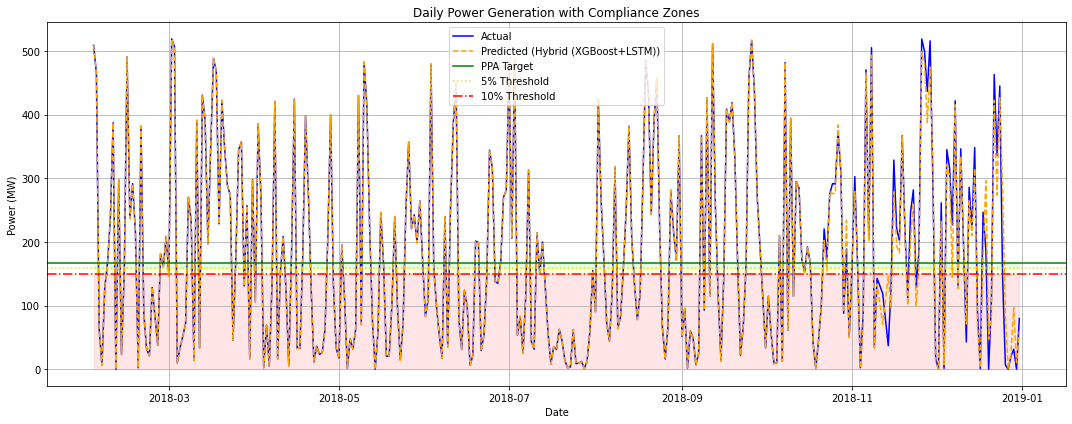

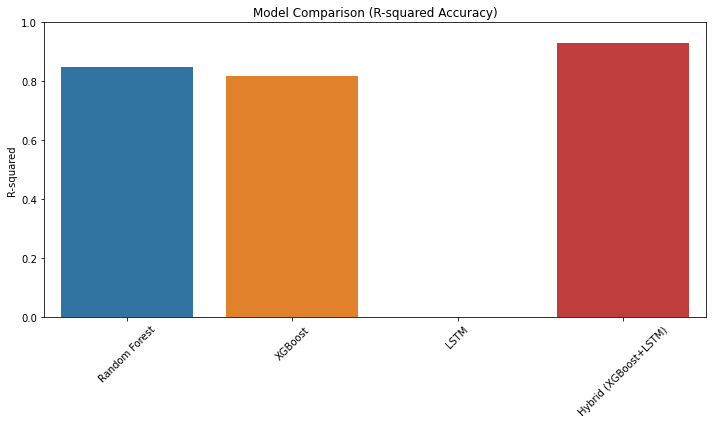

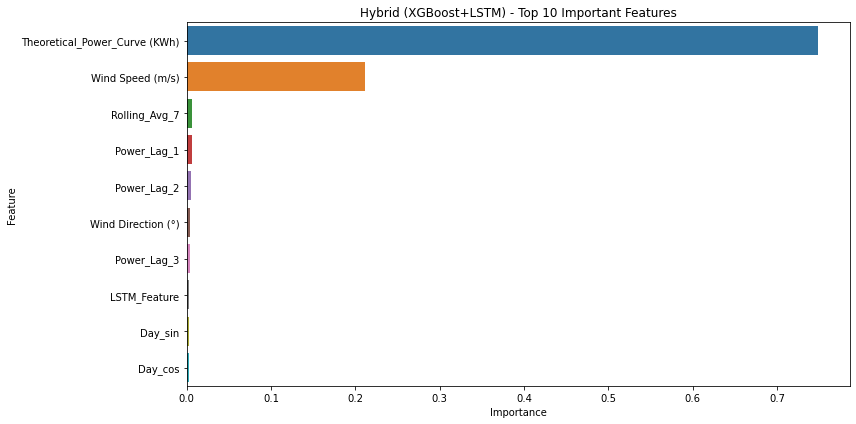

In [14]:
# Time Series Plot
plt.figure(figsize=(15, 6))
plt.plot(results_df['Date'], results_df['Actual (MW)'], label='Actual', color='blue')
plt.plot(results_df['Date'], results_df['Predicted (MW)'], 
         label=f'Predicted ({best_model_name})', color='orange', linestyle='--')
plt.axhline(167.05, color='green', label='PPA Target')
plt.axhline(158.70, color='gold', linestyle=':', label='5% Threshold')
plt.axhline(150.35, color='red', linestyle='-.', label='10% Threshold')
plt.fill_between(results_df['Date'], 158.70, 167.05, color='lime', alpha=0.1)
plt.fill_between(results_df['Date'], 150.35, 158.70, color='yellow', alpha=0.1)
plt.fill_between(results_df['Date'], 0, 150.35, color='red', alpha=0.1)
plt.title('Daily Power Generation with Compliance Zones')
plt.xlabel('Date')
plt.ylabel('Power (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Comparison Plot
plt.figure(figsize=(10, 6))
metrics_df = pd.DataFrame.from_dict(results, orient='index')
sns.barplot(x=metrics_df.index, y='R2', data=metrics_df)
plt.title('Model Comparison (R-squared Accuracy)')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel('R-squared')
plt.tight_layout()
plt.show()

# Feature Importance Plot (if best model is tree-based)
if best_model_name in ['Random Forest', 'XGBoost', 'Hybrid (XGBoost+LSTM)']:
    plt.figure(figsize=(12, 6))
    if best_model_name == 'Random Forest':
        importances = rf_model.feature_importances_
    elif best_model_name == 'XGBoost':
        importances = xgb_model.feature_importances_
    else:
        importances = hybrid_model.feature_importances_
    
    feat_names = features if best_model_name != 'Hybrid (XGBoost+LSTM)' else features + ['LSTM_Feature']
    importance_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
    importance_df = importance_df.sort_values('Importance', ascending=False).head(10)
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'{best_model_name} - Top 10 Important Features')
    plt.tight_layout()
    plt.show()


### Compliance Analysis 

In [15]:
print("\n" + "="*70)
print("COMPLIANCE ANALYSIS")
print("="*70)
compliance = results_df.groupby('Compliance Zone').agg({
    'Date': 'count',
    'Actual (MW)': ['mean', 'min', 'max']
}).rename(columns={'Date': 'Days'})
compliance['Percentage'] = compliance[('Days', 'count')] / len(results_df) * 100
print(compliance)



COMPLIANCE ANALYSIS
                 Days Actual (MW)                         Percentage
                count        mean         min         max           
Compliance Zone                                                     
Penalty           162   57.295839    0.000000  149.195856  49.390244
Within 10%          4  153.370653  152.220071  154.810391   1.219512
Within 5%         162  310.454602  159.155611  518.728905  49.390244


### Predictions 

In [16]:
# Random 25 Predictions

print("\n" + "="*55)
print("RANDOM 25 PREDICTIONS WITH POLICY STATUS")
print("="*55)
print(results_df.sample(50)[['Date', 'Actual (MW)', 'Predicted (MW)', 'Policy Status']].to_string(index=False))


RANDOM 25 PREDICTIONS WITH POLICY STATUS
      Date  Actual (MW)  Predicted (MW) Policy Status
2018-05-02   195.293368      195.088989     Within 5%
2018-08-07   122.373326      122.228706  Penalty Zone
2018-04-14   185.923557      185.470734     Within 5%
2018-09-13   256.395865      256.416321     Within 5%
2018-03-11   390.951802      391.174744     Within 5%
2018-07-18    31.274414       30.937796  Penalty Zone
2018-03-26   344.819341      344.929413     Within 5%
2018-08-06    44.071903       44.134392  Penalty Zone
2018-02-27   161.114190      161.060333     Within 5%
2018-10-12   294.625000      294.529663     Within 5%
2018-06-06    52.588303       52.403294  Penalty Zone
2018-02-17   214.925191      214.561462     Within 5%
2018-08-28   281.113049      281.123932     Within 5%
2018-05-27   220.734273      220.824417     Within 5%
2018-12-13   285.797232      266.379639     Within 5%
2018-10-04     8.812970        8.769988  Penalty Zone
2018-04-28   399.035318      399.384003 